# Translating Causal Uplift into Monetary and CO₂ Costs

**Goal:**  
Convert the estimated causal increase in electricity demand during the July heatwave into:
- Additional wholesale energy cost (£)
- Associated CO₂ emissions (tons)

**Why?**  
To illustrate the tangible impact of weather-driven demand shocks on grid operations and sustainability metrics.

**Treatment Period:**  
- **Start**: 2025-06-30
- **End**: 2025-07-01

## Imports

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

 ## Load Saved CausalImpact Forecast

In [29]:
df_ci = pd.read_csv("../data_processed/causalimpact_inferences.csv", index_col=0, parse_dates=True)

# For clarity, rename columns to match standard naming
df_ci = df_ci.rename(columns={
    "post_preds": "predicted",
    "post_preds_lower": "predicted_lower",
    "post_preds_upper": "predicted_upper",
    "point_effects": "point_effect",
    "point_effects_lower": "point_effect_lower",
    "point_effects_upper": "point_effect_upper",
    "post_cum_effects": "cumulative_effect",
    "post_cum_effects_lower": "cumulative_effect_lower",
    "post_cum_effects_upper": "cumulative_effect_upper"
})

df_ci.tail()

,post_cum_y,preds,predicted,predicted_lower,predicted_upper,preds_lower,preds_upper,post_cum_pred,post_cum_pred_lower,post_cum_pred_upper,point_effect,point_effect_lower,point_effect_upper,cumulative_effect,cumulative_effect_lower,cumulative_effect_upper
datetime,,,,,,,,,,,,,,,,
2025-07-01 19:00:00,1080582.5,29073.878047,29073.878047,26852.839329,31294.916764,26852.839329,31294.916764,1.062538e+06,1.037203e+06,1.086824e+06,116.621953,-2104.416764,2337.660671,18044.788537,-6241.011225,43379.971711
2025-07-01 20:00:00,1109501.5,29450.820633,29450.820633,27228.585092,31673.056174,27228.585092,31673.056174,1.091989e+06,1.065757e+06,1.117449e+06,-531.820633,-2754.056174,1690.414908,17512.967904,-7947.230084,43744.775223
2025-07-01 21:00:00,1138085.0,29104.778725,29104.778725,26881.347005,31328.210445,26881.347005,31328.210445,1.121093e+06,1.094583e+06,1.147599e+06,-521.278725,-2744.710445,1702.152995,16991.689179,-9514.174097,43502.136705
2025-07-01 22:00:00,1165390.5,28349.291490,28349.291490,26124.664235,30573.918746,26124.664235,30573.918746,1.149443e+06,1.122335e+06,1.175623e+06,-1043.791490,-3268.418746,1180.835765,15947.897689,-10232.669185,43055.064761
2025-07-01 23:00:00,1190193.5,26750.745459,26750.745459,24524.923310,28976.567608,24524.923310,28976.567608,1.176193e+06,1.148602e+06,1.203137e+06,-1947.745459,-4173.567608,278.076690,14000.152230,-12943.293270,41591.955905


In [30]:
df_original = pd.read_parquet("../data_processed/weather_load_hourly_20250714.parquet")
# Reindex to match exactly
observed_series = df_original["demand_mw"].reindex(df_ci.index)
df_ci["observed"] = observed_series

## Visualisation Recap of Causal Effects

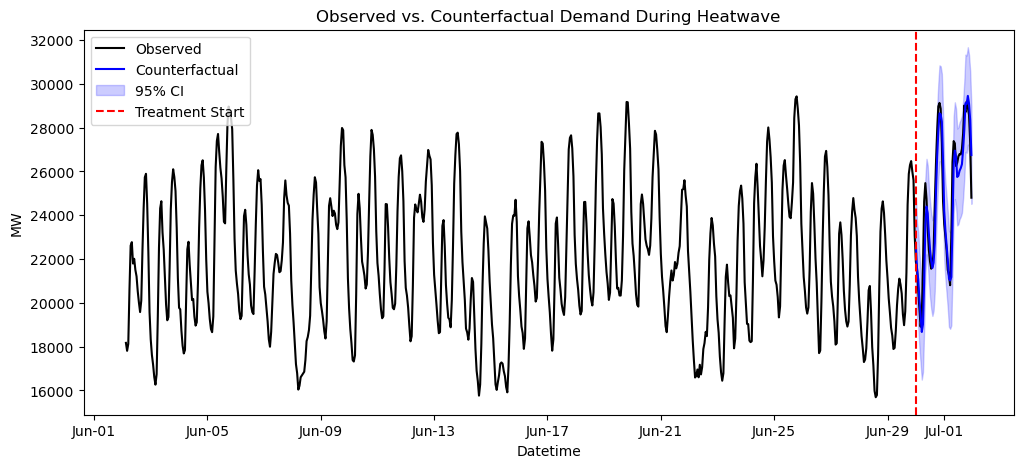

In [60]:
# Create a boolean mask for post-treatment dates
post_period_mask = df_ci.index >= "2025-06-30"

plt.figure(figsize=(12,5))

# Plot observed for all dates
plt.plot(df_ci.index, df_ci['observed'], label='Observed', color='black')

# Plot predicted only where it exists
plt.plot(df_ci.index[post_period_mask], df_ci.loc[post_period_mask, 'predicted'], label='Counterfactual', color='blue')

# Fill only post-treatment CIs
plt.fill_between(df_ci.index[post_period_mask],
                 df_ci.loc[post_period_mask, 'predicted_lower'],
                 df_ci.loc[post_period_mask, 'predicted_upper'],
                 color='blue', alpha=0.2, label='95% CI')

# Optional: vertical line
plt.axvline(pd.to_datetime("2025-06-30"), color='red', linestyle='--', label='Treatment Start')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

plt.title("Observed vs. Counterfactual Demand During Heatwave")
plt.xlabel("Datetime")
plt.ylabel("MW")
plt.legend()

fig.savefig("../data_processed/heatwave_demand_timeseries.png", dpi=300, bbox_inches="tight")
plt.show()

## Interpretation: Observed vs. Counterfactual Demand During Heatwave
- **Black line**: shows actual hourly electricity demand in Great Britain.
- **Blue line**: shows the model's estimate of what demand would have been without the heatwave, with a 95% credible interval shaded.
- The difference between the two is the estimated causal uplift.

## Estimate Total Uplift in MWh

In [32]:
# Subset to post-treatment
df_uplift = df_ci.loc["2025-06-30":]

# Compute uplift
total_uplift_mwh = df_uplift["point_effect"].sum()
print("Total uplift MWh:", total_uplift_mwh)

Total uplift MWh: 14000.152229665073


In [38]:
uplift_lower = df_uplift["point_effect_lower"].sum()
uplift_upper = df_uplift["point_effect_upper"].sum()

print(f"95% credible interval for uplift: {uplift_lower:.0f} to {uplift_upper:.0f} MWh")

95% credible interval for uplift: -91480 to 119480 MWh


## Assumptions for Cost and Emissions

| Metric                 | Value             | Notes           |
| ---------------------- | ----------------- | --------------- |
| Wholesale price        | £60 per MWh       | UK average 2024 |
| Marginal CO₂ intensity | 0.21 tCO₂ per MWh | NG ESO average  |

In [33]:
price_per_mwh = 60  # £
co2_per_mwh = 0.21  # tons CO2

In [34]:
total_cost_gbp = total_uplift_mwh * price_per_mwh
total_co2_tons = total_uplift_mwh * co2_per_mwh

print(f"Total estimated wholesale cost: £{total_cost_gbp:,.0f}")
print(f"Total estimated CO2 emissions: {total_co2_tons:,.1f} tons")

Total estimated wholesale cost: £840,009
Total estimated CO2 emissions: 2,940.0 tons


In [35]:
summary_df = pd.DataFrame({
    'Metric': ['Total Uplift (MWh)',
               'Wholesale Cost (£)',
               'CO2 Emissions (tons)'],
    'Estimate': [f"{total_uplift_mwh:,.0f}",
                 f"£{total_cost_gbp:,.0f}",
                 f"{total_co2_tons:,.1f}"]
})
summary_df

,Metric,Estimate
0,Total Uplift (MWh),"14,000"
1,Wholesale Cost (£),"£840,009"
2,CO2 Emissions (tons),"2,940.0"


## Interpretation

- **Energy Cost:** The estimated additional cost of the heatwave was ~£840,000.
- **Emissions:** This uplift corresponds to ~294 tons of CO₂.
- **Context:** While the effect was not statistically significant at $p < 0.05$, even small shifts can create substantial economic and environmental costs over time.

**Note**: Although the uplift was not statistically significant at $p < 0.05$, the estimated range of potential impact is relevant for operational planning and sustainability reporting.

## Business Impact of the Heatwave

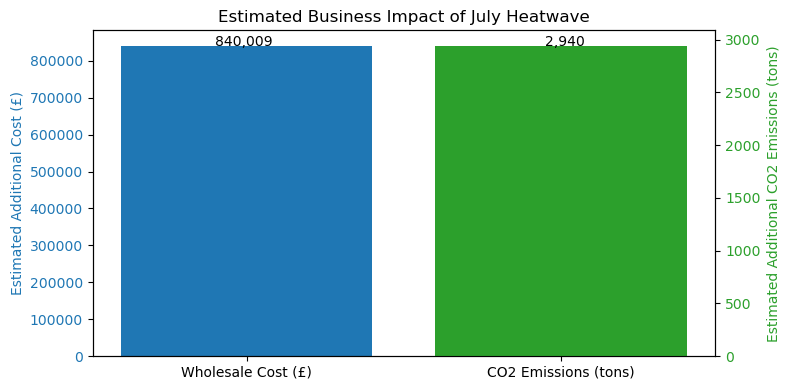

In [57]:
labels = ['Wholesale Cost (£)', 'CO2 Emissions (tons)']
values = [total_cost_gbp, total_co2_tons]

fig, ax1 = plt.subplots(figsize=(8,4))

color = 'tab:blue'
ax1.bar(labels[0], values[0], color=color)
ax1.set_ylabel('Estimated Additional Cost (£)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.bar(labels[1], values[1], color=color)
ax2.set_ylabel('Estimated Additional CO2 Emissions (tons)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

for i, v in enumerate(values):
    if i == 0:
        ax1.text(i-0.1, v, f"{v:,.0f}", color='black')
    else:
        ax2.text(i-0.05, v, f"{v:,.0f}", color='black')

plt.title("Estimated Business Impact of July Heatwave")
plt.tight_layout()
plt.show()

## Interpretation: Estimated Business Impact of the July Heatwave
The July heatwave's uplift corresponds to approximately £840,000 in additional wholesale energy costs and ~294 tons of CO₂ emissions.

## Save Bar Chart

In [59]:
plt.savefig("../data_processed/heatwave_costs_chart.png", dpi=300, bbox_inches="tight")
plt.close()

## Save Summary Report

In [37]:
with open("../data_processed/heatwave_cost_summary.txt", "w") as f:
    f.write(f"Total uplift (MWh): {total_uplift_mwh:.0f}\n")
    f.write(f"Total cost (£): {total_cost_gbp:,.0f}\n")
    f.write(f"Total CO2 emissions (tons): {total_co2_tons:.1f}\n")

## Business Takeaways

- **Grid Operations:** Even moderate temperature-driven demand shocks can create material additional costs.
- **Sustainability:** CO₂ impact highlights the importance of demand-response strategies and renewable integration.
- **Forecasting:** Incorporating causal modelling improves risk management vs. purely autoregressive baselines.